developed a Machine Learning solution to predict the Remaining Useful Life (RUL) of a particular engine component. This kind of problem plays a key role in the field of Predictive Maintenance, where the purpose is to say ‘How much time is left before the next fault?’. To achieve this target I developed a Convolutional NN in Keras that deals with time series in the form of images.

# THE DATASET

 the lack of rare events in the form of observations available. So the first step to achieve good performance is to try to have at disposal the richest dataset that treats every kind of possible scenario.

# Library

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random
import os

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *


Bad key text.latex.unicode in file E:\programs\python\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file E:\programs\python\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file E:\programs\python\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append(f'E:\gitlab\custom-script\script')
from ursar import visual

In [4]:
%reload_ext autoreload

# Load data

In [5]:
train_df = pd.read_csv(f'E:\gitlab\machine-learning\dataset/PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
print('#id:',len(train_df.id.unique()))
train_df = train_df.sort_values(['id','cycle'])
print(train_df.shape)
train_df.head(3)

#id: 100
(20631, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442


# PLOT TRAIN FREQ

Engines have different life durations. The average working time in train data is 206 cycles with a minimum of 128 and a maximum of 362.

medium working time: 206.31
max working time: 362
min working time: 128


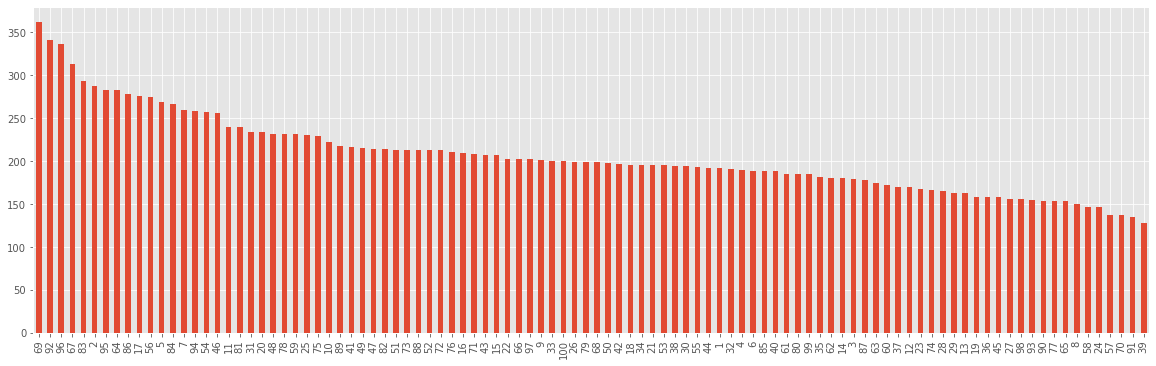

In [6]:
plt.figure(figsize=(20,6))
train_df.id.value_counts().plot.bar()
print("medium working time:", train_df.id.value_counts().mean())
print("max working time:", train_df.id.value_counts().max())
print("min working time:", train_df.id.value_counts().min())

# plotting sensor data for engine ID

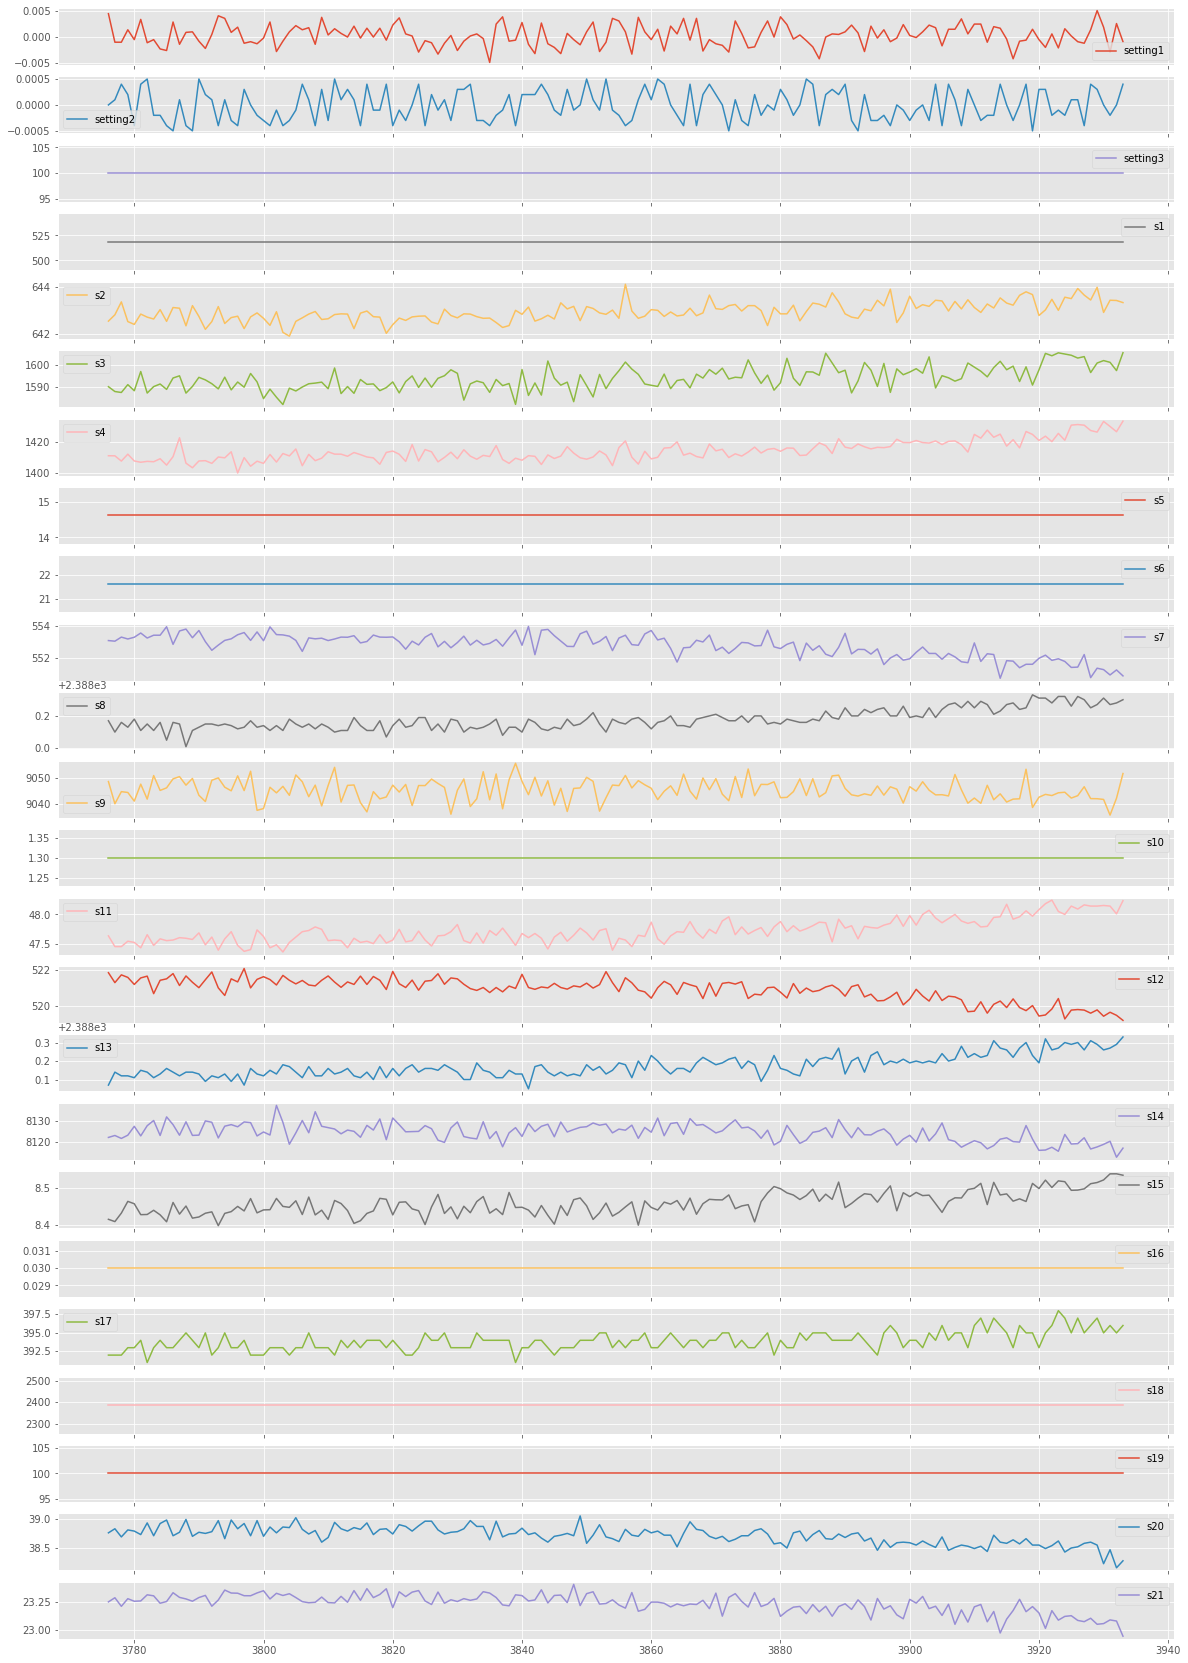

In [7]:
engine_id = train_df[train_df['id'] == 19]

ax1 = engine_id[train_df.columns[2:]].plot(subplots=True, sharex=True, figsize=(20,30))

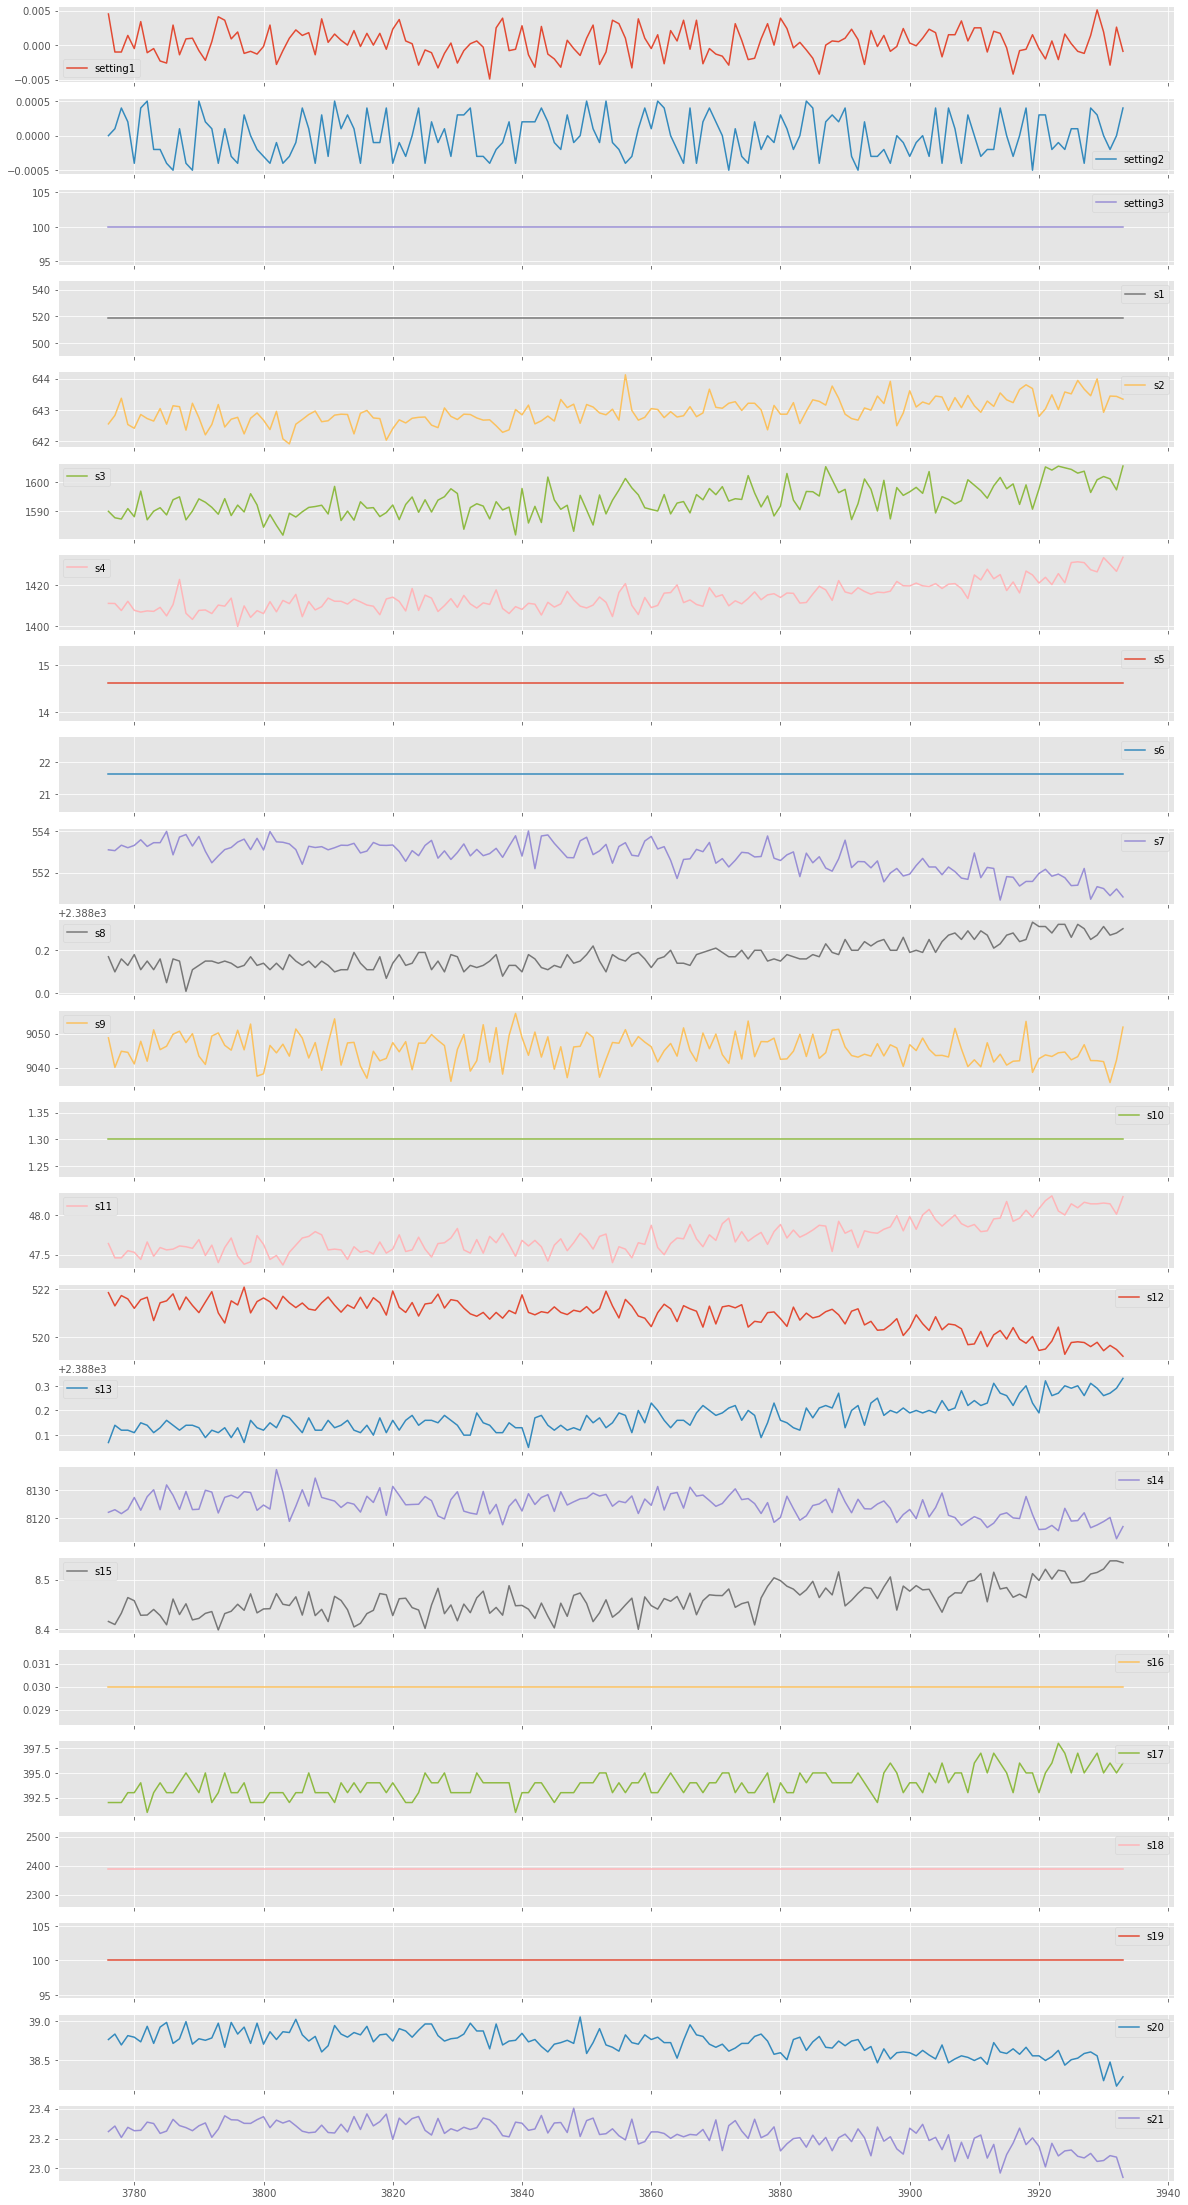

In [8]:
visual.timeseries_plot(train_df,'id',19,2)

# LOAD TEST

In [9]:
test_df = pd.read_csv(f'E:\gitlab\machine-learning\dataset/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
print('#id:',len(test_df.id.unique()))
print(test_df.shape)
test_df.head(3)

#id: 100
(13096, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166


# LOAD GROUND TRUTH

In [10]:
truth_df = pd.read_csv(f'E:\gitlab\machine-learning\dataset/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.columns = ['more']
truth_df = truth_df.set_index(truth_df.index + 1)

print(truth_df.shape)
truth_df.head(3)

(100, 1)


,more
1,112
2,98
3,69


# PREPARE THE DATA

In order to predict the RUL for each engine, we’ve pursued a classification approach, generating the label by ourself

From 0 (fault) to 15 remaining cycles, we’ve labeled as 2; from 16 to 45 cycles, we’ve labeled as 1 and the rest (>46) as 0.

It is clear that in a realistic scenario, the category labeled as 2 is the most economically valuable. Predict this class with good performance will permit us to operate an adequate program of maintenance, avoiding future faults and saving money.

in order to have at our disposal the maximum number of data for the train, we split the series with a fixed window and a sliding of 1 step. For example, engine1 have 192 cycles in train, with a window length equal to 50 we extract 142 time series with length 50:
window1 -> from cycle0 to cycle50, window2 -> from cycle1 to cycle51, … , window142 -> from cycle141 to cycle50, window191. Each window is labeled with the corresponding label of the final cycle taken into account by the window.

# CALCULATE RUL TRAIN 

In [11]:
train_df['RUL']=train_df.groupby(['id'])['cycle'].transform(max)-train_df['cycle']
train_df.RUL[0:10]

0    191
1    190
2    189
3    188
4    187
5    186
6    185
7    184
8    183
9    182
Name: RUL, dtype: int64

# ADD NEW LABEL TRAIN 

In [12]:
w1 = 45
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# SCALE TRAIN DATA

In [13]:
def scale(df):
    #return (df - df.mean())/df.std()
    return (df - df.min())/(df.max()-df.min())

for col in train_df.columns:
    if col[0] == 's':
        train_df[col] = scale(train_df[col])
#     elif col == 'cycle':
#         train_df['cycle_norm'] = scale(train_df[col])
        
train_df = train_df.dropna(axis=1)
train_df.head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,...,s12,s13,s14,s15,s17,s20,s21,RUL,label1,label2
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,1.0,0.726248,0.242424,...,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191,0,0
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,1.0,0.628019,0.212121,...,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190,0,0
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,1.0,0.710145,0.272727,...,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189,0,0
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,1.0,0.740741,0.318182,...,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188,0,0
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,1.0,0.668277,0.242424,...,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187,0,0


# CALCULATE RUL TEST

In [14]:
truth_df['max'] = test_df.groupby('id')['cycle'].max() + truth_df['more']
test_df['RUL'] = [truth_df['max'][i] for i in test_df.id] - test_df['cycle']

# ADD NEW LABEL TEST

In [15]:
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

# SCALE TEST DATA 

In [16]:
for col in test_df.columns:
    if col[0] == 's':
        test_df[col] = scale(test_df[col])
#     elif col == 'cycle':
#         test_df['cycle_norm'] = scale(test_df[col])
        
test_df = test_df.dropna(axis=1)
test_df.head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,...,s12,s13,s14,s15,s17,s20,s21,RUL,label1,label2
0,1,1,0.65625,0.692308,0.596215,0.421968,0.282214,1.0,0.608871,0.365854,...,0.534247,0.325581,0.152259,0.347076,0.375,0.500000,0.620099,142,0,0
1,1,2,0.34375,0.230769,0.182965,0.504025,0.225240,1.0,0.800403,0.292683,...,0.634703,0.395349,0.277907,0.227709,0.500,0.645455,0.645718,141,0,0
2,1,3,0.53125,0.538462,0.419558,0.464814,0.346130,1.0,0.651210,0.390244,...,0.591324,0.325581,0.192892,0.533557,0.500,0.700000,0.681104,140,0,0
3,1,4,0.77500,0.461538,0.413249,0.391587,0.449867,1.0,0.643145,0.341463,...,0.456621,0.372093,0.217896,0.282359,0.250,0.627273,0.620382,139,0,0
4,1,5,0.60000,0.461538,0.435331,0.471306,0.357974,1.0,0.661290,0.292683,...,0.632420,0.325581,0.187891,0.337009,0.125,0.618182,0.676008,138,0,0


# GEN SEQUENCE

In [17]:
sequence_length = 50

def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,142),(50,192)
    # 0 50 (start stop) -> from row 0 to row 50
    # 1 51 (start stop) -> from row 1 to row 51
    # 2 52 (start stop) -> from row 2 to row 52
    # ...
    # 141 191 (start stop) -> from row 141 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

# SEQUENCE COL: COLUMNS TO CONSIDER

In [27]:
sequence_cols = []
for col in train_df.columns:
    if col[0] == 's':
        sequence_cols.append(col)
#sequence_cols.append('cycle_norm')
print(sequence_cols)

['setting1', 'setting2', 's2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']


# GENERATE X TRAIN TEST

In [19]:
x_train, x_test = [], []
for engine_id in train_df.id.unique():
    for sequence in gen_sequence(train_df[train_df.id==engine_id], sequence_length, sequence_cols):
        x_train.append(sequence)
    for sequence in gen_sequence(test_df[test_df.id==engine_id], sequence_length, sequence_cols):
        x_test.append(sequence)
    
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

print("X_Train shape:", x_train.shape)
print("X_Test shape:", x_test.shape)

X_Train shape: (15631, 50, 17)
X_Test shape: (8162, 50, 17)


# GENERATE Y TRAIN TEST

In [20]:
y_train, y_test = [], []
for engine_id in train_df.id.unique():
    for label in gen_labels(train_df[train_df.id==engine_id], sequence_length, ['label2'] ):
        y_train.append(label)
    for label in gen_labels(test_df[test_df.id==engine_id], sequence_length, ['label2']):
        y_test.append(label)
    
y_train = np.asarray(y_train).reshape(-1,1)
y_test = np.asarray(y_test).reshape(-1,1)


print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (15631, 1)
y_test shape: (8162, 1)


# ENCODE LABEL

In [21]:
y_train = to_categorical(y_train)
print(y_train.shape)

y_test = to_categorical(y_test)
print(y_test.shape)

(15631, 3)
(8162, 3)


# FROM TIME SERIES TO IMAGES

transform the series at our disposal in images; in order to feed our classification model with them.

when we try to transform time series into images we always make use of spectrogram. This choice is clever but not always the best onem

Spectrograms are powerful but their usage may result in a loss of information, particularly if we try to approach the problem in a computer vision way.

To be efficient a 2D CNN requires spatial invariance; this builds on the assumption that features of a classical image (like a photo) carry the same meaning regardless of their location. On the other side, a spectrogram implies a two dimensions representation made by two different units (frequency and time).

transform my time series windows (of length 50 cycles) making use of Recurrence Plots

we investigate how to use recurrence plots as pre-processing step for time-series, so we can classifiy them with convolutional neural nets. Since CNNs require images as inputs to be useful, one has to convert a time-series to an image. A typical approach is to convert the time-series to a spectrogram. This is disadvantageous since in a spectrogram it matters where an effect appears in contrast to CNNs where it is assumed that a feature is of the same kind, no matter where in the picture it is. The usage of recurrence plots as visualization of the recurrence structure of a time-series is hence advantageous. In this kernel we will investigate the notion of recurrence plots and how to use it for time-series classification.

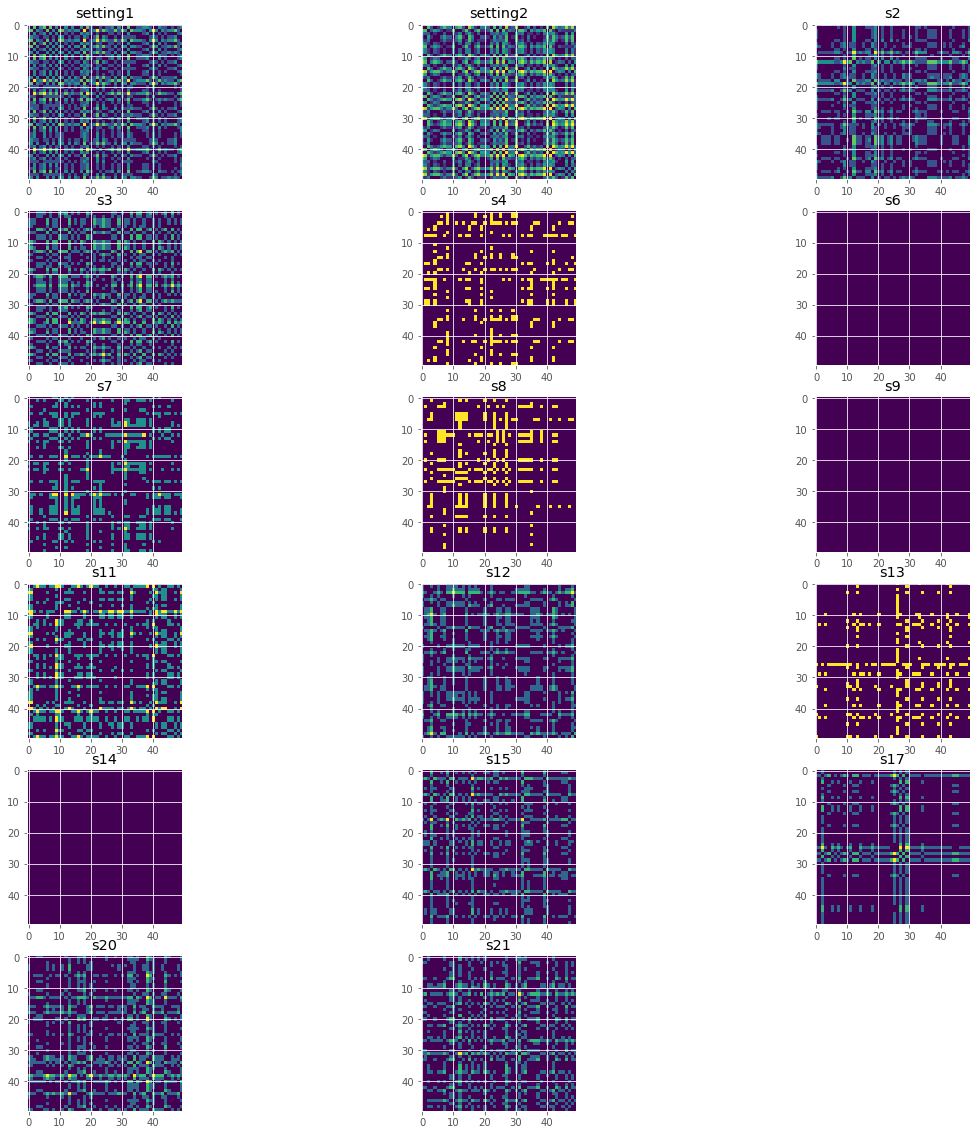

In [28]:
visual.timeseries_to_images(x_train,sequence_cols)

we are able to generate an image of 50x50 for every time series at our disposal (I’ve excluded the constant time series with 0 variances). So every single observation is made by an array of images of size 50x50x17 (17 are the time series with no zero variance) like below.

# TRANSFORM X TRAIN TEST IN IMAGES

In [29]:
x_train_img = np.apply_along_axis(visual.recurrence_plot, 1, x_train).astype('float16')
print(x_train_img.shape)

x_test_img = np.apply_along_axis(visual.recurrence_plot, 1, x_test).astype('float16')
print(x_test_img.shape)

(15631, 50, 50, 17)
(8162, 50, 50, 17)


# MODEL

In [30]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 17)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        4928      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 64)          0

# training

training with early stopping and setting session for paralel

In [32]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=6)

history = model.fit(x_train_img, y_train, 
          batch_size=512, 
          epochs=25, 
          callbacks=[es],
          validation_split=0.2, 
          verbose=2)

Train on 12504 samples, validate on 3127 samples
Epoch 1/25
12504/12504 - 30s - loss: 0.1949 - accuracy: 0.9144 - val_loss: 0.2361 - val_accuracy: 0.8993
Epoch 2/25
12504/12504 - 10s - loss: 0.1948 - accuracy: 0.9171 - val_loss: 0.2673 - val_accuracy: 0.9044
Epoch 3/25
12504/12504 - 6s - loss: 0.1689 - accuracy: 0.9291 - val_loss: 0.2618 - val_accuracy: 0.8909
Epoch 4/25
12504/12504 - 6s - loss: 0.1490 - accuracy: 0.9361 - val_loss: 0.2649 - val_accuracy: 0.8919
Epoch 5/25
12504/12504 - 6s - loss: 0.1382 - accuracy: 0.9393 - val_loss: 0.2894 - val_accuracy: 0.9025
Epoch 6/25
12504/12504 - 6s - loss: 0.1294 - accuracy: 0.9459 - val_loss: 0.2912 - val_accuracy: 0.8989
Epoch 7/25
12504/12504 - 7s - loss: 0.1139 - accuracy: 0.9540 - val_loss: 0.3403 - val_accuracy: 0.8561
Epoch 8/25
Restoring model weights from the end of the best epoch.
12504/12504 - 7s - loss: 0.1073 - accuracy: 0.9563 - val_loss: 0.3237 - val_accuracy: 0.8830
Epoch 00008: early stopping


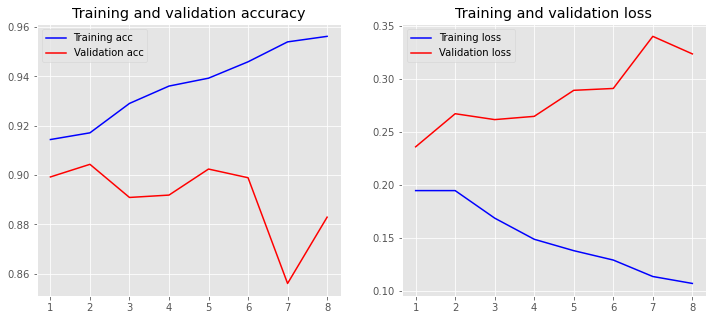

In [33]:
visual.plot_nn(history)

# evaluate with testing dataset

In [34]:
model.evaluate(x_test_img, y_test, verbose=2)

8162/8162 - 5s - loss: 0.1811 - accuracy: 0.9322


[0.1811100026001312, 0.932247]

# matrix

In [39]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    # Hide grid lines
    plt.grid(False)

    # Hide axes ticks
    plt.xticks([])
    plt.yticks([])
    plt.zticks([])
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [40]:
print(classification_report(np.where(y_test != 0)[1], model.predict_classes(x_test_img)))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7426
           1       0.58      0.64      0.61       676
           2       0.34      0.95      0.50        60

    accuracy                           0.93      8162
   macro avg       0.64      0.85      0.69      8162
weighted avg       0.94      0.93      0.94      8162



AttributeError: module 'matplotlib.pyplot' has no attribute 'zticks'

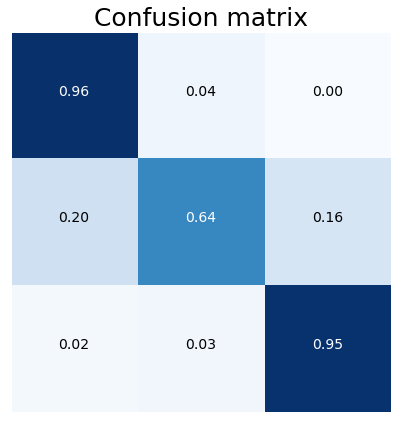

In [41]:
cnf_matrix = confusion_matrix(np.where(y_test != 0)[1], model.predict_classes(x_test_img))
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(np.where(y_test != 0)[1]), title="Confusion matrix")

plt.show()

From the confusion matrix we can see that our model can well discriminate when an engine is close to failure (2 labels: <16 cycles remaining) or when it works normally (0 label: >45 cycles). A little bit of noise is present in the intermediate class (>15, <46 cycles). We are satisfied to achieve a great and clear result for the prediction of class 2 — i.e. near to failure.